# Time-Based Algorithm: blind SQL injection vulnerability detection

In this notebook, I consider the problem of blind SQL injection vulnerability detection using a custom time-based algorithm. Specifically, making mutiple requests (half with a high sleep delay and the other half with a low sleep delay) to the url being tested and comparing their RTTs to decide whether the url is vulnerable (label 1) or safe (label 0)

**Optimization:** The goal is optimize the algorithm for speed and accuracy. More speficically, it needs to have a true positive rate of less than 0.0001 (1 in 10,000) and a sleep delay that returns a RTT of less than 10 seconds on average

Import libraries

In [244]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
sns.set()
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline

# Part (a): Data Exploration

1. Collect RTTS of safe and vulnerable URLs and save them into CSV files.

2. Compare the safe and vulnerable RTTs by visualizing them and comparing their mean (as well as other metrics).


**1. Collect RTTS of vulnerable and safe urls**

In [245]:
def collect_rtts(page_type = 'safe', n_pages = 100, sleep_delay = 0):
    '''
    Collects RTTS from URLs and saves them into CSV file
    '''
    
    if sleep_delay != 0:
        query = 'SLEEP({})'.format(sleep_delay)
        file_name = '{}_{}_{}.csv'.format(page_type, n_page, sleep_delay)
    
    else:
        query = '1'
        file_name = '{}_{}.csv'.format(page_type, n_pages)
    
    with open(file_name, 'w') as file:
        writer = csv.writer(file, delimiter=',', lineterminator='\n')
        writer.writerow(['URL', 'RTT'])
        for i in range(1, n_pages+1):
            url = 'http://localhost:5000/{}/{}/page?id={}'.format(page_type, page_num, query)
            response = requests.get(url)
            row = [url, response.elapsed.total_seconds()]
            writer.writerow(row)

In [246]:
# Read data
safe_df = pd.read_csv('Data/safe_100.csv')
vul_df = pd.read_csv('Data/vulnerable_100.csv')
vul_delay_df = pd.read_csv('Data/vulnerable_100_1.csv') # 1 second sleep delay injected

In [247]:
safe_df.head()

,URL,RTT
0,http://localhost:5000/safe/1/page?id=1,6.554458
1,http://localhost:5000/safe/2/page?id=1,3.299523
2,http://localhost:5000/safe/3/page?id=1,2.255223
3,http://localhost:5000/safe/4/page?id=1,2.725735
4,http://localhost:5000/safe/5/page?id=1,4.646487


**2. Compare the RTTs and try to find a trend.**

In [248]:
print('Safe url statistics')
safe_df.describe()

Safe url statistics


,RTT
count,100.000000
mean,3.199542
std,1.691694
min,0.446409
25%,2.014172
50%,2.885159
75%,3.881203
max,10.794784


In [249]:
print('Vulnerable url with delay statistics')
vul_delay_df.describe()

Vulnerable url with delay statistics


,RTT
count,100.000000
mean,8.141448
std,2.086598
min,5.724981
25%,6.786474
50%,7.486104
75%,8.908915
max,17.916236


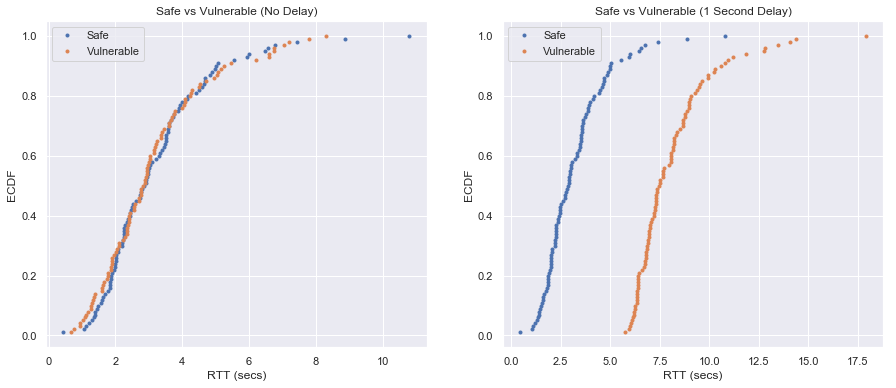

In [304]:
# Calculating CDFs
safe_ecdf = ECDF(safe_df['RTT'])
vul_ecdf = ECDF(vul_df['RTT'])
vul_delay_ecdf = ECDF(vul_delay_df['RTT']) 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#fig.tight_layout()

ax[0].plot(safe_ecdf.x, safe_ecdf.y, marker='.', linestyle='none')
ax[0].plot(vul_ecdf.x, vul_ecdf.y, marker='.', linestyle='none')

ax[1].plot(safe_ecdf.x, safe_ecdf.y, marker='.', linestyle='none')
ax[1].plot(vul_delay_ecdf.x, vul_ecdf.y, marker='.', linestyle='none')

_ = ax[0].set_title('Safe vs Vulnerable (No Delay)')
_ = ax[0].legend(('Safe', 'Vulnerable'), loc='best')
_ = ax[0].set_xlabel('RTT (secs)')
_ = ax[0].set_ylabel('ECDF')

_ = ax[1].set_title('Safe vs Vulnerable (1 Second Delay)')
_ = ax[1].legend(('Safe', 'Vulnerable'), loc='best')
_ = ax[1].set_xlabel('RTT (secs)')
_ = ax[1].set_ylabel('ECDF')

In [251]:
print('The mean of the safe URL without a sleep injection is: {}'.format(np.mean(safe_df['RTT'])))

The mean of the safe URL without a sleep injection is: 3.1995424299999997


In [252]:
print('The mean of the vulnerable URL with 1 second sleep injection: {}'.format(np.mean(vul_delay_df['RTT'])))

The mean of the vulnerable URL with 1 second sleep injection: 8.141448309999998


**Observation:** As suspected, without a sleep delay injected, both safe and vulnerable urls have a similar distribution of RTTs. On the other hand, adding a sleep delay of 1 second to the vulnerables urls increseases their delays by about 5 seconds. Also, in some cases, there seems to be an overlap of RTTs between safe urls and vulnerable urls with a 1 second sleep injection. This could be avoided by increasing the sleep delay of the vulnerable url. 

## Part (b): Time-based Algorithm

Since the RTT of a safe url can sometimes overlap with the RTT of a vulnerable url with a 1 second delay, it can be challenging to distinguish between the two without introducing false positives or making the elapsed time of the request too long. 

In order to combat this issue, one can collect a distribution of RTTs (of two different types) and compare them to each other in order to find a noticible difference in their central tendency. 

1. Collect data of pairs of RTTs with high and low sleep delay
2. Compare their central tendency. 

**1. Collect data of pairs of RTTs with high and low sleep delay**

**Note:** In order to make the pairs of distributions more comparable and minimise the elapsed time of the requests,
a script was written to make these requests asynchronously which required me to run it outside of this jupyter notebook

In [273]:
# Data collected for 25 pairs (50 requests total) of high (1 second) and low (0.05 seconds) delays. 
vul_pairs_df = pd.read_csv('Data/vulnerable_pairs_50_1_0.05.csv')
safe_pairs_df = pd.read_csv('Data/safe_pairs_50_1_0.05.csv')

vul_pairs_high = vul_pairs_df[vul_pairs_df['High Delay'] == 1]
vul_pairs_low = vul_pairs_df[vul_pairs_df['High Delay'] == 0]

safe_pairs_high = safe_pairs_df[safe_pairs_df['High Delay'] == 1]
safe_pairs_low = safe_pairs_df[safe_pairs_df['High Delay'] == 0]

In [274]:
vul_pairs_df.head()

,URL,High Delay,RTT
0,http://localhost:5000/vulnerable/1/page?id=SLE...,0,3.579312
1,http://localhost:5000/vulnerable/1/page?id=SLE...,1,7.351426
2,http://localhost:5000/vulnerable/1/page?id=SLE...,0,2.721237
3,http://localhost:5000/vulnerable/1/page?id=SLE...,1,10.874254
4,http://localhost:5000/vulnerable/1/page?id=SLE...,0,2.934227


**2. Compare their central tendency.**

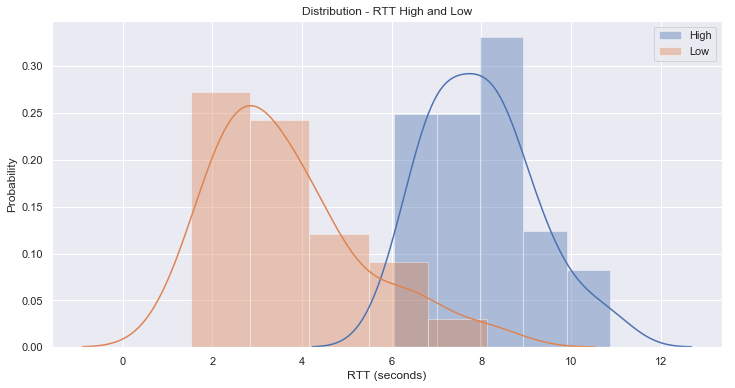

In [305]:
# Calculating CDFs
vul_pairs_high_ecdf = ECDF(pairs_high['RTT']) 
vul_pairs_low_ecdf = ECDF(pairs_low['RTT']) 

plt.figure(figsize=(12, 6))
sns.distplot(vul_pairs_high['RTT'])
sns.distplot(vul_pairs_low['RTT'])

_ = plt.xlabel("RTT (seconds)")
_ = plt.ylabel('Probability')
_ = plt.legend(('High', 'Low'), loc='best')
_ = plt.title('Distribution - RTT High and Low')

In [295]:
vul_high_median = np.median(vul_pairs_high['RTT'])
vul_low_median = np.median(vul_pairs_low['RTT'])

print('The median of the high delay for a vulnerable url is: {}'.format(vul_high_median))
print('The median of the low delay for a vulnerable url is: {}'.format(vul_low_median))

The median of the high delay for a vulnerable url is: 7.978613814
The median of the low delay for a vulnerable url is: 3.1059598669999997


In [296]:
print('The difference of their median is: {}'.format(vul_high_median - vul_low_median))

The difference of their median is: 4.872653947


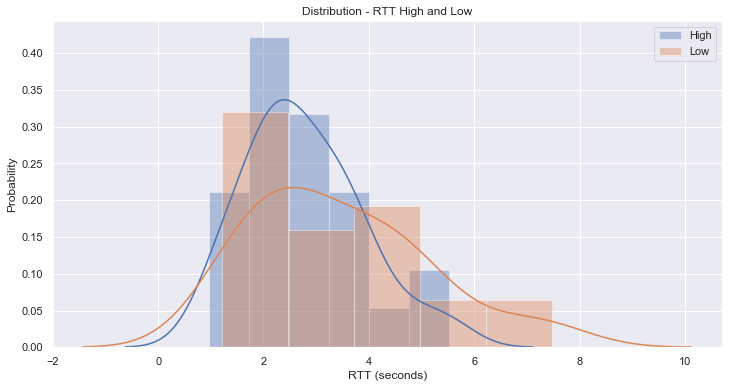

In [306]:
# Calculating CDFs
vul_pairs_high_ecdf = ECDF(pairs_high['RTT']) 
vul_pairs_low_ecdf = ECDF(pairs_low['RTT']) 

plt.figure(figsize=(12, 6))
sns.distplot(safe_pairs_high['RTT'])
sns.distplot(safe_pairs_low['RTT'])

_ = plt.xlabel("RTT (seconds)")
_ = plt.ylabel('Probability')
_ = plt.legend(('High', 'Low'), loc='best')
_ = plt.title('Distribution - RTT High and Low')

In [298]:
safe_high_median = np.median(safe_pairs_high['RTT'])
safe_low_median = np.median(safe_pairs_low['RTT'])
print('The median of the high delay for a safe url is: {}'.format(safe_high_median))
print('The median of the low delay for a safe url is: {}'.format(safe_low_median))

The median of the high delay for a safe url is: 2.578487667
The median of the low delay for a safe url is: 3.096570514


In [299]:
print('The difference of their median is: {}'.format(safe_high_median - safe_low_median))

The difference of their median is: -0.5180828470000001


With this in mind, the following 4 parameters will be helpful in building an algorithm that gives us the results we need:

**1. High Delay:** A sleep delay that is long.

**2. Low Delay:** As sleep delay that is short. 

**3. Number of Requests:** Number of requests for which we should collect RTTs. Half of these requests will be made using a high delay and the other half with a low delay.

**4. Difference:** The number used to compared the difference in the median in the pairs (high and low) of requests. If the central tendency of the pairs is greater than this difference than the url is labeled as vulnerable. 

## Part (c) Evaluating Results

Since our goal is to optimize for speed and specificity, then we will need to pick a High Delay that is small enough that the program completes within a few seconds and a difference high enough that the FPR stays below 0.0001.

1. Test 10,000+ safe and vulnerable urls and evaluate their results.
2. Tweak parameters and repeat steps 1 and 2 until the desired metrics are reached

**1. Test 10,000+ safe and vulnerable urls and evaluate their results**

**Note:** Since the algorithm makes url requets asynchronously, it needed to be run outside this jupyter notebook. The code can be found The code can be found inside `time_based_test.py`

In [257]:
safe_test_df = pd.read_csv('Data/safe_results_10500_0.8_0.03_24_3.csv')
vul_test_df = pd.read_csv('Data/vulnerable_results_10500_0.8_0.03_24_3.csv')

In [258]:
safe_test_df.head()

,Test Result
0,0
1,0
2,0
3,0
4,0


In [259]:
# Get False Positive Rate (FPR)
fpr = float(np.sum(safe_test_df['Test Result'])/safe_test_df.shape[0])
print('The False Positive Rate is: {}'.format(fpr))


# Get False Negative Rate (FNR)
fnr = float(vul_test_df[vul_test_df['Test Result'] == 0].count()/vul_test_df.shape[0])
print('The False Negative Rate is: {}'.format(fnr))

The False Positive Rate is: 0.0
The False Negative Rate is: 0.09342857142857143


**2. Tweak parameters and repeat steps 1 and 2 until the desired metrics are reached**